In [1]:
import tensorflow as tf
import numpy as np

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
model.trainable=False
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [3]:
def load_and_process_img(img_path):
    img = load_img(img_path, target_size=(512,512))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [4]:
def deprocess(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:,:, ::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

def show_img(image):
    if len(image.shape)==4:
        img=np.squeeze(image, axis=0)
    img = deprocess(img)
    plt.grid(False)
    #plt.xticks([])
    #plt.yticks([])
    plt.imshow(img)
    return

In [86]:
from google.colab import files
files.upload()
from IPython.display import clear_output
clear_output()

In [106]:
content_img = "tajmahal.jpeg"
content_path = "/content/tajmahal.jpeg"
style_img = "starry_night.jpeg"
style_path = "/content/starry_night.jpeg"
content = load_and_process_img(content_path)
style = load_and_process_img(style_path)

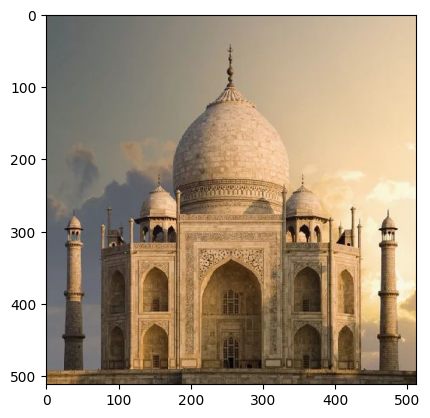

In [107]:
plt.figure()
show_img(content)

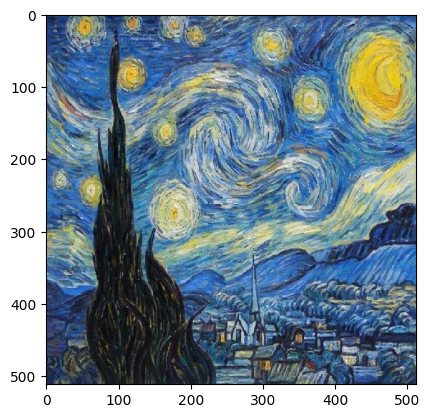

In [108]:
show_img(style)

In [125]:
#content_layer = 'block5_conv1'
content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)
style_models = [Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers]


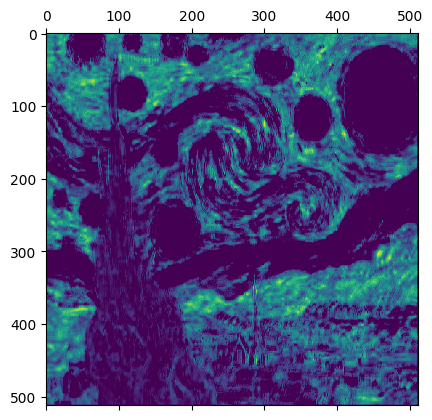

In [123]:
#ACTIVATIONS OF STYLE LAYERS
index=0
a_S = style_models[index](style)
plt.matshow(a_S[0,:,:,18])

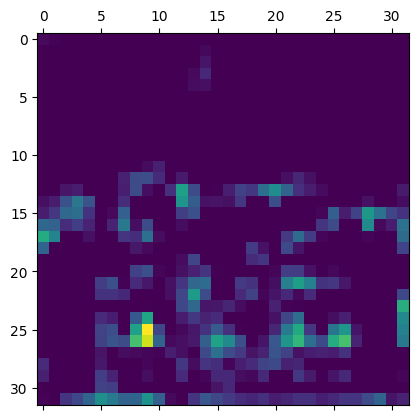

In [126]:
#ACTIVATION OF CONTENT LAYER
a_C = content_model(content)
plt.matshow(a_C[0,:,:,9])

In [127]:
def content_cost(content, generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  cost = tf.reduce_mean(tf.square(a_C - a_G))
  return cost


In [128]:
def gram_matrix(x):
  channels = int(x.shape[-1])
  a = tf.reshape(x, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram/tf.cast(n, tf.float32)

In [129]:
lam = 1/len(style_models)

def style_cost(style, generated):
  J_style = 0
  current_cost = []
  for s_model in style_models:
    a_S = s_model(style)
    a_G = s_model(generated)
    gram_S = gram_matrix(a_S)
    gram_G = gram_matrix(a_G)
    current_cost.append(tf.reduce_mean(tf.square(gram_S - gram_G)))
  #J_style weightages may vary
  J_style = (4/6)*current_cost[0] + (1/6)*current_cost[1] + (1/6)*current_cost[2]
  return J_style

In [130]:
generated_img = []

def compute_total_cost(content, style, generated, alpha, beta):
  J_content = content_cost(content, generated)
  J_style = style_cost(style, generated)
  J_cost = alpha * J_content + beta * J_style
  return J_cost



In [135]:
def optimize(content_path, style_path, iterations, alpha, beta, lr):
  content = load_and_process_img(content_path)
  style = load_and_process_img(style_path)
  generated = tf.Variable(content)
  #generated = np.copy(content)

  opt = tf.optimizers.Adam(learning_rate=lr)
  J_min = 1e12 + 0.1
  result = None
  for i in range(iterations + 1):
        # Use tf.function for potential performance improvement
        with tf.GradientTape() as tape:
            J_cost = compute_total_cost(content, style, generated, alpha, beta)

        grads = tape.gradient(J_cost, generated)
        opt.apply_gradients([(grads, generated)])

        if J_cost < J_min:
            J_min = J_cost
            result = generated.numpy()
        if i % 100 == 0:
            print('cost at iteration ' + str(i) + ' = ' + str(J_cost.numpy()))
            generated_img.append(generated.numpy())
  return result

In [136]:
itr = 2000
alpha = 10
beta = 100
lr = 2
result = optimize(content_path, style_path, itr, alpha, beta, lr)

cost at iteration 0 = 16478484000.0
cost at iteration 100 = 118526616.0
cost at iteration 200 = 36015876.0
cost at iteration 300 = 20251548.0
cost at iteration 400 = 13503388.0
cost at iteration 500 = 9796058.0
cost at iteration 600 = 7468125.5
cost at iteration 700 = 5880637.0
cost at iteration 800 = 4740588.0
cost at iteration 900 = 3891215.5
cost at iteration 1000 = 3239523.8
cost at iteration 1100 = 2727180.0
cost at iteration 1200 = 2316221.5
cost at iteration 1300 = 1981467.2
cost at iteration 1400 = 1705763.4
cost at iteration 1500 = 1476224.1
cost at iteration 1600 = 1283330.4
cost at iteration 1700 = 1120409.1
cost at iteration 1800 = 982074.5
cost at iteration 1900 = 863832.9
cost at iteration 2000 = 762431.5


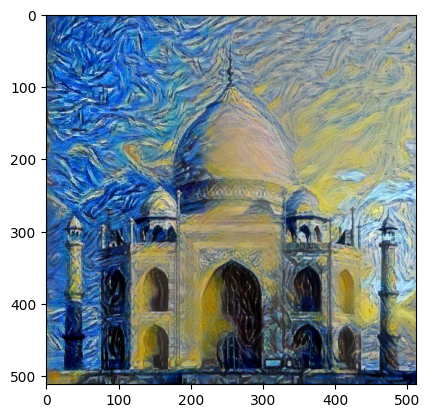

In [137]:
show_img(result)

In [56]:
result = np.squeeze(generated_img[-1], axis = 0)
result = deprocess(result)
result = tf.keras.preprocessing.image.array_to_img(result)
result = result.save('result.jpg')